In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io, filters
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_216'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
load_directory

'/oak/stanford/groups/trc/data/Ilana/2P/data/fly_216/func_0/background_subtraction/functional_channel_2_moco.h5'

In [3]:
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def apply_butter_highpass(data, z, cutoff, order, fs):

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)
    hpf_data = butter_highpass_filter(data[:,:,z, :], cutoff, fs, order)
    return hpf_data

In [4]:
#filter requirements 
order = 2     # ?? wtf is this??
fs = 1.8      # sample rate, Hz
cutoff = 0.01  # desired cutoff frequency of the filter, Hz

In [5]:
%%time

with h5py.File(load_directory, 'r') as hf:
        data = hf['data'][:] 
        dims = np.shape(data)
        print("Data shape is {}".format(dims))
        hpf_total = []
        for z in range(dims[-2]):
            hpf_data = apply_butter_highpass(data, z, cutoff, order, fs)
            hpf_total.append(hpf_data)
        hpf_total = np.array(hpf_total)
        hpf_total = np.transpose(hpf_total, (1,2,0,3))
        dims_hpf = np.shape(hpf_total)
        print("High Pass Filter Data shape is {}".format(dims_hpf))

Data shape is (256, 128, 49, 3384)
High Pass Filter Data shape is (256, 128, 49, 3384)
CPU times: user 1min 12s, sys: 37.1 s, total: 1min 49s
Wall time: 2min 13s


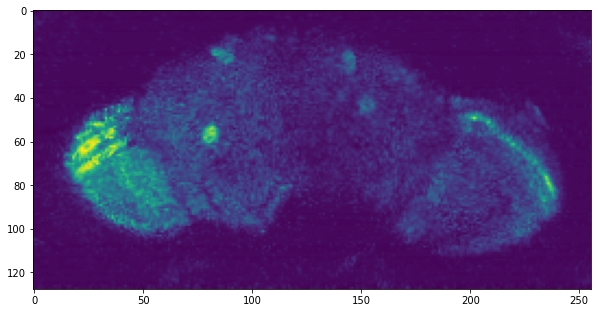

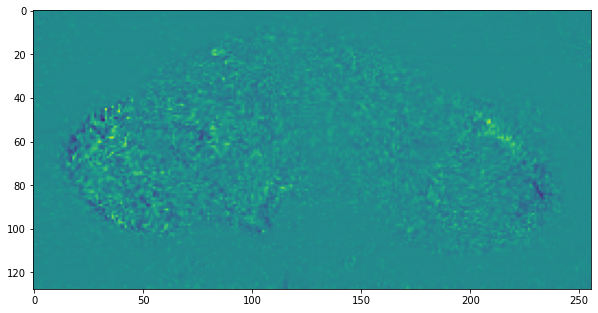

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(data[:,:,20,1000].T)
plt.figure(figsize=(10,10))
plt.imshow(hpf_total[:,:,20, 1000].T)

In [7]:
def make_flat_img(x):
    max_proj = np.max(x, axis=2)
    fd = max_proj.shape[1]*max_proj.shape[0]
    flat_img = max_proj.reshape(fd, max_proj.shape[2])
    return np.mean(flat_img, axis=0)

In [8]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd1, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms

loading photodiode data... done


In [9]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [10]:
np.shape(fictrac_timestamps)

(180000,)